In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
        
    return captions

In [3]:
captions = readTextFile('./Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

In [4]:
captions = captions.split('\n')[:-1]

In [5]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [6]:
descriptions = {} #Dictionary to Map each Image with the list of captions it has

for cap in captions:
    img_name = cap.split('\t')[0].split('.')[0]
    caption = cap.split('\t')[1]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(caption)

In [7]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

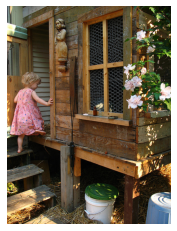

(500, 375, 3)


In [8]:
img = cv2.imread('Flickr_Data/Images/1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()
print(img.shape)

In [9]:
# Data Cleaning
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [sent for sent in sentence if len(sent)>1]
    sentence = ' '.join(sentence)
    
    return sentence

In [10]:
clean_text('A cat is sitting over the house number 64')

'cat is sitting over the house number'

In [11]:
for img_name in descriptions:
    for i in range(len(descriptions[img_name])):
        descriptions[img_name][i] = clean_text(descriptions[img_name][i])

In [12]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# Write the data to text file
with open('descriptions_1.txt','w') as f:
    f.write(str(descriptions))

In [14]:
# Vocabulary
descriptions = None
with open('descriptions_1.txt','r') as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [15]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
# Vocab
vocab = set()
for key in descriptions:
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [17]:
len(vocab)

8424

In [18]:
total_words = []
for key in descriptions:
    [total_words.append(word) for sent in descriptions[key] for word in sent.split()]

In [19]:
len(total_words)

373837

In [20]:
# Filter words from the Vocab according to certain threshold frequency
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

In [21]:
len(freq_cnt)

8424

In [22]:
# Sort this dictionary according to the freq count
vocab_ = [word for word in freq_cnt if freq_cnt[word]>10]

In [23]:
len(vocab_)

1845

In [24]:
train_file_data = readTextFile('Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [25]:
train = train_file_data.split('\n')[:-1]
test = test_file_data.split('\n')[:-1]

In [26]:
train = [train_img.split('.')[0] for train_img in train]
test = [test_img.split('.')[0] for test_img in test]

In [27]:
# Prepare Training Descriptions for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for train_img_id in train:
    train_descriptions[train_img_id] = []
    
    for caption in descriptions[train_img_id]:
        train_descriptions[train_img_id].append('startseq ' + caption + ' endseq')

In [28]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [29]:
model_new = Model(model.input,model.layers[-2].output)
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [30]:
def preprocess_img(img_path):
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) #(1,224,224,3)
    img = preprocess_input(img) #Normalisation
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


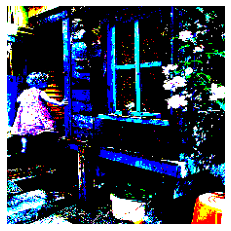

(1, 224, 224, 3)


In [31]:
img = preprocess_img('Flickr_Data/Images/1000268201_693b08cb0e.jpg')
plt.imshow(img[0])
plt.axis('off')
plt.show()
print(img.shape)

In [32]:
def encode_img(img_path):
    img = preprocess_img(img_path)
    feature_vector = model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [33]:
encode_img('Flickr_Data/Images/1000268201_693b08cb0e.jpg')

array([0.04154468, 0.1707591 , 0.292768  , ..., 0.05094025, 0.31319624,
       0.86007285], dtype=float32)

In [34]:
'''start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    encoding_train[img_id] = encode_img('Flickr_Data/Images/'+img_id+'.jpg')
    
    if ix%100==0:
        print('Encoding in Progress Time Step %d '%ix)

        
end_t = time()
print('Total Time Taken :',end_t-start)'''

"start = time()\nencoding_train = {}\n#image_id -->feature_vector extracted from Resnet Image\n\nfor ix,img_id in enumerate(train):\n    encoding_train[img_id] = encode_img('Flickr_Data/Images/'+img_id+'.jpg')\n    \n    if ix%100==0:\n        print('Encoding in Progress Time Step %d '%ix)\n\n        \nend_t = time()\nprint('Total Time Taken :',end_t-start)"

In [35]:
# Store everything to the disk
#with open('encoded_train_features.pkl','wb') as f:
    #pickle.dump(encoding_train,f)

In [36]:
'''start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    encoding_test[img_id] = encode_img('Flickr_Data/Images/'+img_id+'.jpg')
    
    if ix%100==0:
        print('Encoding in Progress Time Step %d '%ix)

        
end_t = time()
print('Total Time Taken :',end_t-start)'''

"start = time()\nencoding_test = {}\n#image_id -->feature_vector extracted from Resnet Image\n\nfor ix,img_id in enumerate(test):\n    encoding_test[img_id] = encode_img('Flickr_Data/Images/'+img_id+'.jpg')\n    \n    if ix%100==0:\n        print('Encoding in Progress Time Step %d '%ix)\n\n        \nend_t = time()\nprint('Total Time Taken :',end_t-start)"

In [37]:
# Store everything to the disk
#with open('encoded_test_features.pkl','wb') as f:
 #   pickle.dump(encoding_test,f)

In [38]:
# Data pre-processing for Captions
word_to_idx = {}
idx_to_word = {}
total_words = vocab_

for idx,word in enumerate(total_words):
    word_to_idx[word] = idx+1
    idx_to_word[idx+1] = word

In [39]:
# Two Special Words
word_to_idx['startseq'] = 1846
idx_to_word[1846] = 'startseq'

word_to_idx['endseq'] = 1847
idx_to_word[1847] = 'endseq'
vocab_size = len(word_to_idx) + 1

In [40]:
max_len = 0

for key in train_descriptions:
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)

35


In [41]:
# Data Loader (Generator)
def data_generator(train_descriptions,encoding_train,word_to_index,max_len,batch_size):
    X1,X2,Y = [],[],[]
    n = 0
    
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                    
                    X1,X2,Y = [],[],[]
                    n = 0

In [42]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [43]:
f.close()

In [44]:
def get_embedding_matrix():
    emb_dim = 50
    embedding_matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    
    return embedding_matrix

In [45]:
embedding_matrix = get_embedding_matrix()

In [46]:
embedding_matrix.shape

(1848, 50)

In [47]:
# Model Architechture

# Encoder
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [48]:
# Decoder
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [49]:
# Important thing -> Pre Initialize Embedding Layer 
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [50]:
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [51]:
# Training of Model
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [52]:
f_encoding_train = open('encoded_train_features.pkl','rb')
f_encoding_test = open('encoded_test_features.pkl','rb')

encoding_train = pickle.load(f_encoding_train)
encoding_test = pickle.load(f_encoding_test)

In [53]:
encoding_train

{'2513260012_03d33305cf': array([0.28047314, 0.40687397, 0.08379973, ..., 0.9107919 , 0.04341817,
        0.09577907], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00244133, 0.07775952, ..., 0.32224596, 0.3387253 ,
        0.82698166], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.649989  , 0.45327228, 0.35990572, ..., 0.01184076, 0.17420328,
        0.04910804], dtype=float32),
 '488416045_1c6d903fe0': array([0.59114206, 0.24315473, 0.        , ..., 1.1071404 , 0.44211772,
        0.4111294 ], dtype=float32),
 '2644326817_8f45080b87': array([0.08373525, 0.55374795, 0.0366526 , ..., 0.11103816, 1.0484875 ,
        0.        ], dtype=float32),
 '218342358_1755a9cce1': array([1.5750597 , 0.3306421 , 0.34105465, ..., 0.24407965, 0.03760226,
        0.03851034], dtype=float32),
 '2501968935_02f2cd8079': array([0.08495866, 1.2882224 , 0.03415347, ..., 0.1563588 , 0.5512882 ,
        1.3358809 ], dtype=float32),
 '2699342860_5288e203ea': array([0.3491123 , 0.30767432, 

In [54]:
train()

Epoch 1/1
2000/2000 [==============================] - 859s 429ms/step - loss: 4.2834
Epoch 1/1
2000/2000 [==============================] - 861s 431ms/step - loss: 3.5729
Epoch 1/1
2000/2000 [==============================] - 860s 430ms/step - loss: 3.3224
Epoch 1/1
2000/2000 [==============================] - 918s 459ms/step - loss: 3.1698
Epoch 1/1
2000/2000 [==============================] - 985s 493ms/step - loss: 3.0596
Epoch 1/1
2000/2000 [==============================] - 1016s 508ms/step - loss: 2.9726
Epoch 1/1
2000/2000 [==============================] - 868s 434ms/step - loss: 2.9050
Epoch 1/1
2000/2000 [==============================] - 863s 431ms/step - loss: 2.8526
Epoch 1/1
2000/2000 [==============================] - 864s 432ms/step - loss: 2.8038
Epoch 1/1
2000/2000 [==============================] - 831s 415ms/step - loss: 2.7661
Epoch 1/1
2000/2000 [==============================] - 823s 411ms/step - loss: 2.7323
Epoch 1/1
2000/2000 [==============================] 

In [56]:
model = load_model('./model_weights/model_19.h5')

In [80]:
def predict_caption(photo):
    in_text = 'startseq'
    
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        y_pred = model.predict([photo,sequence])
        y_pred = y_pred.argmax() #Word with max prob always -> Greedy Sampling
        word_pred = idx_to_word[y_pred]
        in_text += (' ' + word_pred)
        
        if word_pred=='endseq':
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption
        

dog is running on the grass


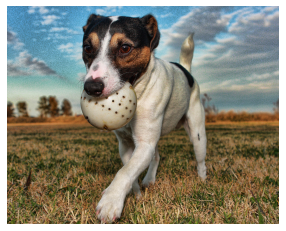

baby in green outfit is sitting in chair with his arms out


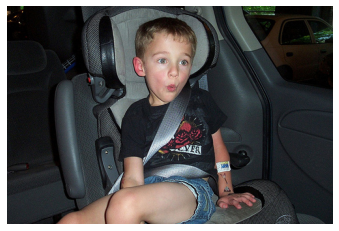

man is hiking up rocky hill


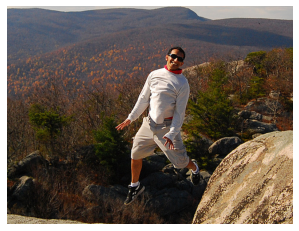

person is standing in natural rock


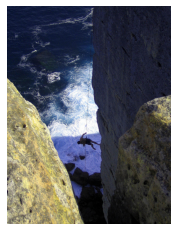

dog is running on the grass


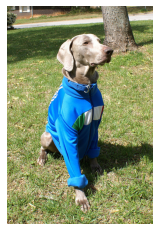

two children are playing in water fountain


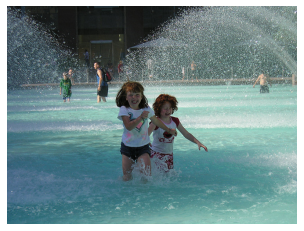

dog jumps over barrier


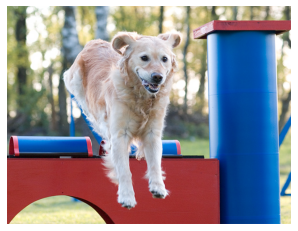

dog running through field


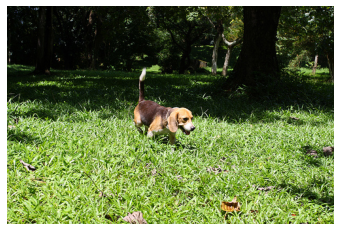

brown dog is running on the grass


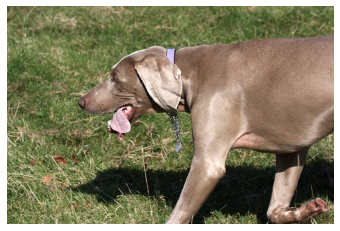

little girl in striped outfit is holding on the herself


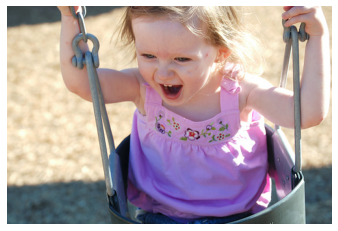

black dog is running on the beach


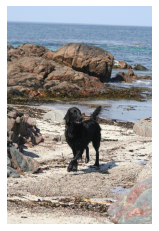

man in red shirt and black shorts is running on the sprinklers


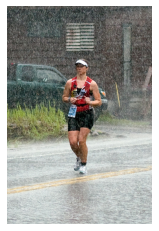

dog is jumping over hurdle


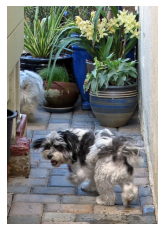

land is splashing over the ocean


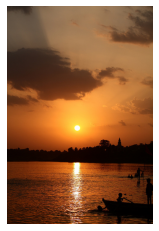

man in blue shirt and jeans is standing in front of brick wall


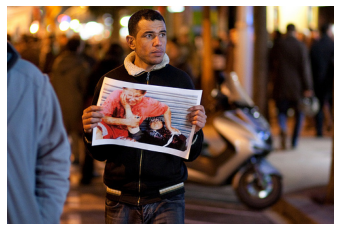

In [81]:
# Pick some random Images and see results
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_vector = encoding_test[img_name].reshape((1,2048))
    caption = predict_caption(photo_vector)
    print(caption)
    img = plt.imread('Flickr_Data/Images/'+img_name+'.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()